##### Installing Required Libraries : 

Satpy library will be installed. Satpy is a python library that can be used to work with various earth-observing satellite instrument data and was created by the Pytroll open source software group.

The high level functionality of Satpy related to geo stationary satellite data stitching project includes:

- reading data files
- compositing data products together (ex. RGB images)
- resampling data to new geographic projections
- writing data to on-disk formats
- using the data with other python-based visualization tools

In [9]:
# ! conda install -c conda-forge satpy # you can also use pip, but install rasterio seperatly in that way. 
# ! pip install patool
# ! pip install matplotlib
# ! conda install cartopy # For window os it is highly recommended use conda to install cartopy. for linux it is possible and to install cartopy using pip.

##### Importing Required Libraries

In [10]:
from glob import glob
import os
from satpy import Scene
from pyresample import create_area_def
from utils import find_format, find_reader, geo_area_def
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

##### Reading Data

Satpy's main interface for working with data is the `Scene` class. We can provide the `Scene` with data files and load them with a "reader". 

There are many readers available in Satpy, but the three readers related to this project are as below :

| Reader      | Description |
|:-----------:|:-----------:|
| `'abi_l1b'`              |  reads individual GOES ABI L1B NetCDF4 files. The files read by this reader are described in the [official PUG document](https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf)|
| `'seviri_l1b_native'`    |  reads and calibrates MSG-SEVIRI L1.5 image data in binary format. The format is explained in the [MSG Level 1.5 Native Format File Definition.](https://www-cdn.eumetsat.int/files/2020-04/pdf_fg15_msg-native-format-15.pdf)|
|   `'ahi_hsd'`            |  reads Advanced Himawari Imager (AHI) Binary data (standard format data)       |

`TO_DO` : Write a utility function which finds the directory of latest downloaded files

In [3]:
# base_dir = './Goes_abi/tmp/GOES-18/ABI-L1b-RadF/2024/063/13'# Goes-18
base_dir = './Goes_abi/tmp/GOES-16/ABI-L1b-RadF/2024/063/13'# Goes-16
# base_dir = './Meteosat_seviri/tmp'# Meteosat
# base_dir = './Himawari_ahi/tmp/HIMAWARI-9/AHI-L1b-FLDK/2024/03/03/1340'# Himawari

filenames_format = find_format(base_dir)

reader=find_reader(filenames_format)
filenames = glob( base_dir + f'/*.{filenames_format}')

scn = Scene(reader=reader, filenames=filenames)

We've now created a `Scene` object. Under the hood Satpy has determined what we can access. We haven't actually loaded any data so our dict-like `Scene` object is empty. In other words we first load/read metadata by creating `Scene` object. 

In [4]:
scn.available_dataset_names()

['C06']

Then we will read/load all or subset of available dataset. 

In [5]:
channels = scn.available_dataset_names()
scn.load(channels)

Now we loaded some dataset and consequently are able to access those.

In [6]:
scn['IR_108']

c:\Users\Sadra\miniconda3\envs\geosat_down\lib\site-packages\pyproj\crs\crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


<xarray.DataArray 'reshape-0576dc0aa41c8a84f8ff9c70c42dfc29' (y: 3712, x: 3712)>
dask.array<truediv, shape=(3712, 3712), dtype=float32, chunksize=(928, 3712), chunktype=numpy.ndarray>
Coordinates:
    acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT NaT ... NaT NaT NaT NaT NaT
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x         (x) float64 5.566e+06 5.563e+06 5.56e+06 ... -5.566e+06 -5.569e+06
Attributes: (12/18)
    orbital_parameters:       {'projection_longitude': 45.5, 'projection_lati...
    time_parameters:          {'nominal_start_time': datetime.datetime(2024, ...
    units:                    K
    wavelength:               10.8 µm (9.8-11.8 µm)
    standard_name:            toa_brightness_temperature
    platform_name:            Meteosat-9
    ...                       ...
    name:                     IR_108
    resolution:               3000.403165817
    calibration:              brightness_temperature
    modifiers:                ()
    _satpy_id:                DataID(name='IR_108', wavelength=WavelengthRang...
    ancillary_variables:      []

##### Resampling Data

One of the more complex topics when it comes to working with earth-observing satellite data is geographic projections and resampling data to these different projections.

The `'area'` attribute of our Satpy data is a special `AreaDefinition` and it defines the geographic area that our data covers. Under `Projection` we see a python dictionary of projection parameters to define that flat plane representation of the Earth. Our ABI data is on a `'geos'` or Geostationary Satellite View coordinate system where position is measured in meters on the the X and Y axes. You can learn more about that on the PROJ site [here](https://proj.org/operations/projections/geos.html).

In the current project we need to have the data in `'web mercator'` projection system(EPSG:3857).
So we need to resample the data to this system.  

We can do this using Satpy's `Scene.resample` method which provides multiple algorithms for resampling data.

- `'native'` resampler can be very useful when you need to combine bands from the same instrument that have different resolutions.

- Other resamplers (`nearest` and so on) are used to change the projection of the dataset. for this case, we should determine the geographic area of interest using a `AreaDefenition` object. this object is created more easily using Pyresample's `create_area_def` utility function.

Pysat utilizes Pyresample, a Python package designed for resampling geospatial image data, for the purpose of resampling operations.

Next we will create `AreaDefenition` object for Goes_East and Goes_West satellites using create_area_def utility function. 

In [6]:
geo_area_defenition = geo_area_def(scene=scn)

Then we will resample the data using created `AreaDefenition` object. 

In [7]:
scn_resamp = scn.resample(destination=geo_area_defenition)

##### Writing Data

Satpy makes it possible to save datasets in multiple formats, with `writers` designed to save in a given format.The default `writer` is geotiff writer.

In [8]:
scn_resamp.save_datasets(
    writer="geotiff",
    filename="{platform_name}_{name}_{start_time:%Y%m%d_%H%M%S}.tif",
    base_dir=base_dir)

c:\Users\Sadra\miniconda3\envs\geosat_down\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\Sadra\miniconda3\envs\geosat_down\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\Sadra\miniconda3\envs\geosat_down\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\Sadra\miniconda3\envs\geosat_down\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\Sadra\miniconda3\envs\geosat_down\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\Sadra\miniconda3\envs\geosat_down\lib\site-packages\dask\core.py:119: R

##### Visualizing Data

Although data can be visualized in specialized GIS software after exporting the data in well-known geospatial raster formats like GeoTIFF, being able to visualize data directly in Python can be really beneficial in some cases.

Text(0.5, 1.0, 'C06')

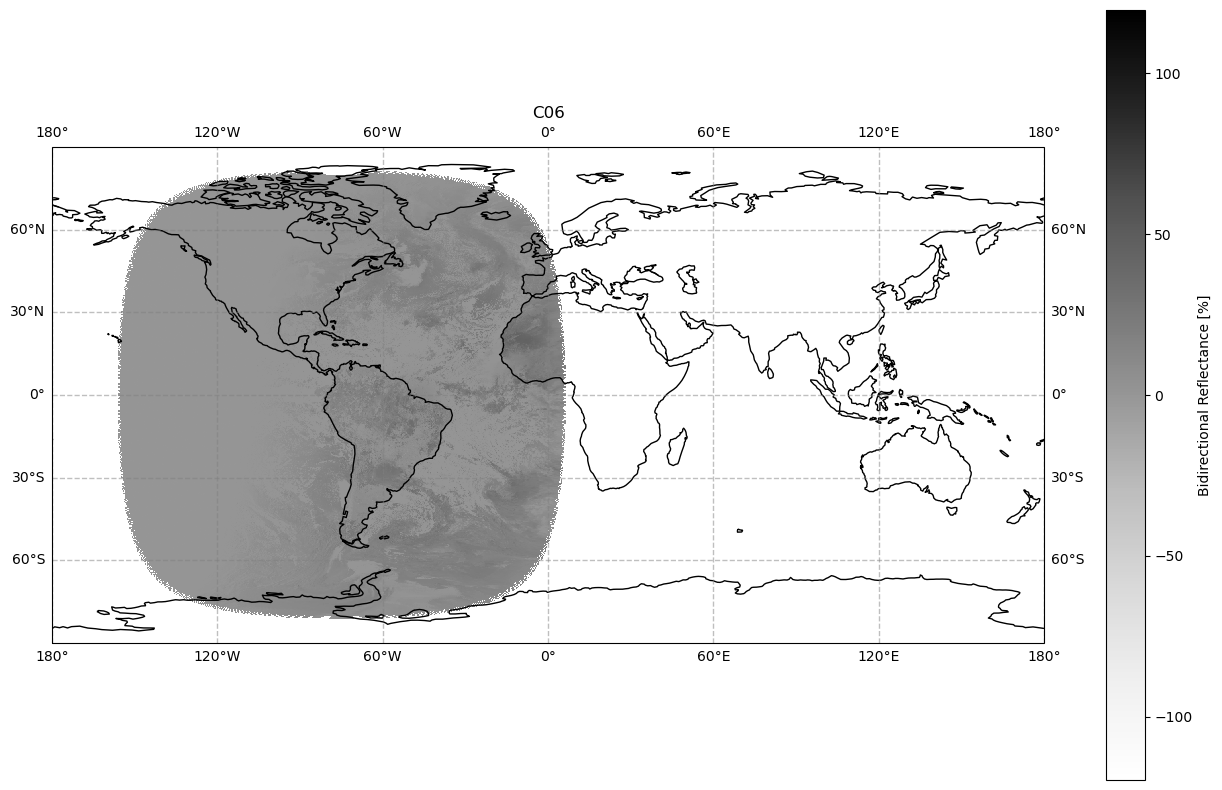

In [25]:
channel = 'C06'
crs = scn[channel].attrs['area'].to_cartopy_crs()
plt.figure(figsize=(16,10))
ax = plt.axes(projection=ccrs.PlateCarree())

cmap = 'Greys'  # Example colormap without transparency

dataset = scn[channel]
dataset.plot.imshow(transform=crs, cmap=cmap)
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.title(f"platform_name : {scn[channel].attrs['platform_name']}  \n channel : {scn[channel].attrs['name']}  \n start_time : {scn[channel].attrs['start_time']}  \n end_time : {scn[channel].attrs['end_time']} ")